In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import GRU, Embedding, Dropout, Dense
import seaborn as sns
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import warnings
import string
warnings.filterwarnings('ignore')
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('memotion_dataset_7k/labels.csv')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df = df.drop(columns = ['image_name','text_ocr', 'humour', 'sarcasm', 'offensive', 'motivational'])
df.head()

,text_corrected,overall_sentiment
0,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,positive
1,The best of #10 YearChallenge! Completed in le...,positive
2,Sam Thorne @Strippin ( Follow Follow Saw every...,positive
3,10 Year Challenge - Sweet Dee Edition,positive
4,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,neutral


In [3]:
meme_text = pd.DataFrame()
meme_text['text'] = df.text_corrected
meme_text['sentiment'] = df.overall_sentiment
meme_text.head()

,text,sentiment
0,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,positive
1,The best of #10 YearChallenge! Completed in le...,positive
2,Sam Thorne @Strippin ( Follow Follow Saw every...,positive
3,10 Year Challenge - Sweet Dee Edition,positive
4,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,neutral


In [4]:
cleaned = meme_text.copy()
cleaned.dropna(inplace=True)
cleaned.isnull().any()

text         False
sentiment    False
dtype: bool

In [5]:
target = cleaned['sentiment']
target = pd.get_dummies(target)
labels = []
for _, i in target.iterrows():
    labels.append(np.argmax(i))
labels[0:5]

[2, 2, 2, 2, 1]

In [6]:
cleaned.shape,target.shape

((6987, 2), (6987, 3))

<AxesSubplot:xlabel='sentiment', ylabel='count'>

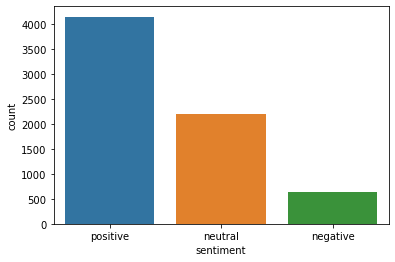

In [7]:
sns.countplot(cleaned.sentiment)

In [8]:
cleaned['sentiment'].value_counts()

positive    4156
neutral     2200
negative     631
Name: sentiment, dtype: int64

In [9]:
import nlpaug
import nlpaug.augmenter.word as naw
def Augmentation(text, labels):
    aug = naw.SynonymAug(aug_src='wordnet',aug_max=3)
    augmented_sentences = []
    augmented_sentences_labels = []
    for i in range(0, len(text)):
        if np.argmax(labels.iloc[i]) == 0:
            t = 0
            temps = aug.augment(text.iloc[i],n=6)
        elif np.argmax(labels.iloc[i]) == 1:
            t = 1
            temps = aug.augment(text.iloc[i],n=2)
        else:
            augmented_sentences.append(text.iloc[i])
            augmented_sentences_labels.append(2)
            continue
        for sent in temps:
            augmented_sentences.append(sent)
            augmented_sentences_labels.append(t)
        
    return augmented_sentences,augmented_sentences_labels

In [10]:
text, sent = Augmentation(cleaned.text, target)
cleaned = pd.DataFrame()
cleaned['text'] = text
cleaned['sentiment'] = sent

In [11]:
from tensorflow.keras.utils import to_categorical
sent = to_categorical(sent)
pd.DataFrame(text).shape, pd.DataFrame(sent).shape

((12342, 1), (12342, 3))

In [12]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", 
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", 
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]

In [13]:
def remove_stopwords(data):
    data['text'] = data['text'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stopwords)]))
    return data

def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result
 
data_without_stopwords = []
data_without_stopwords = remove_stopwords(cleaned)
data_without_stopwords['text']= data_without_stopwords['text'].apply(lambda cw : remove_tags(cw))
data_without_stopwords['text'] = data_without_stopwords['text'].str.replace('[{}]'.format(string.punctuation), ' ')

In [14]:
text = data_without_stopwords.text
sentiment = data_without_stopwords['sentiment']

In [15]:
y = sent
pd.DataFrame(y).head()

,0,1,2
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,1.0,0.0


In [16]:
X_train, X_test,Y_train, Y_test = train_test_split(text, y, test_size=0.3, random_state = 45)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = 0.4)
X_train.shape, X_test.shape, X_val.shape

((8639,), (2221,), (1482,))

In [17]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

words_to_index = tokenizer.word_index

In [18]:
def read_glove_vector(glove_vec):
    with open(glove_vec, 'r', encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            w_line = line.split()
            curr_word = w_line[0]
            word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
    return word_to_vec_map

In [19]:
word_to_vec_map = read_glove_vector('glove.6B.50d.txt')

maxLen = 150
units = 1024

In [20]:
vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['moon'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
    embedding_vector = word_to_vec_map.get(word)
    if embedding_vector is not None:
        emb_matrix[index-1, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)

In [21]:
def create_model():

    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(0.5))
    model.add(GRU(units))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    return model

In [22]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 50)           654300    
_________________________________________________________________
dropout (Dropout)            (None, 150, 50)           0         
_________________________________________________________________
gru (GRU)                    (None, 1024)              3305472   
_________________________________________________________________
dense (Dense)                (None, 3)                 3075      
Total params: 3,962,847
Trainable params: 3,308,547
Non-trainable params: 654,300
_________________________________________________________________


In [23]:
X_train_indices = tokenizer.texts_to_sequences(X_train)
X_val_indices = tokenizer.texts_to_sequences(X_val)

In [24]:
X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen, padding='post')
X_val_indices = pad_sequences(X_val_indices, maxlen=maxLen, padding='post')
X_train_indices.shape, X_val_indices.shape

((8639, 150), (1482, 150))

In [25]:
history = model.fit(pd.DataFrame(X_train_indices), Y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(pd.DataFrame(X_val_indices), Y_val),
                    batch_size=64)

Epoch 1/10
135/135 [==============================] - 20s 131ms/step - loss: 1.1384 - accuracy: 0.3381 - val_loss: 1.1009 - val_accuracy: 0.3050
Epoch 2/10
135/135 [==============================] - 17s 130ms/step - loss: 1.1108 - accuracy: 0.3327 - val_loss: 1.1072 - val_accuracy: 0.3664
Epoch 3/10
135/135 [==============================] - 18s 132ms/step - loss: 1.1073 - accuracy: 0.3368 - val_loss: 1.0965 - val_accuracy: 0.3664
Epoch 4/10
135/135 [==============================] - 18s 133ms/step - loss: 1.1027 - accuracy: 0.3462 - val_loss: 1.1009 - val_accuracy: 0.3050
Epoch 5/10
135/135 [==============================] - 18s 134ms/step - loss: 1.1024 - accuracy: 0.3416 - val_loss: 1.1029 - val_accuracy: 0.3286
Epoch 6/10
135/135 [==============================] - 18s 134ms/step - loss: 1.1022 - accuracy: 0.3409 - val_loss: 1.0974 - val_accuracy: 0.3664
Epoch 7/10
135/135 [==============================] - 18s 135ms/step - loss: 1.0997 - accuracy: 0.3485 - val_loss: 1.1011 - val_ac

In [26]:
X_test_indices = tokenizer.texts_to_sequences(X_test)

X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding='post')

In [27]:
y_pred = model.predict(X_test_indices)

In [28]:
yt = np.argmax(Y_test, axis = 1)
yp = np.argmax(y_pred, axis = 1)

In [33]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
accuracy_score(yt, yp)

0.360198108959928

In [31]:
print(classification_report(yt,yp))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       701
           1       0.36      1.00      0.53       800
           2       0.00      0.00      0.00       720

    accuracy                           0.36      2221
   macro avg       0.12      0.33      0.18      2221
weighted avg       0.13      0.36      0.19      2221



Text(33.0, 0.5, 'Truth')

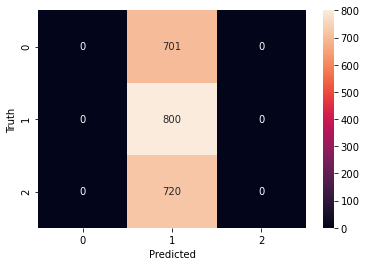

In [34]:
from matplotlib import pyplot as plt
import seaborn as sn
cm = confusion_matrix(yt, yp)
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')